In [1]:
from scipy.integrate import odeint
import scipy.special as math
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import itertools

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt

## SIR

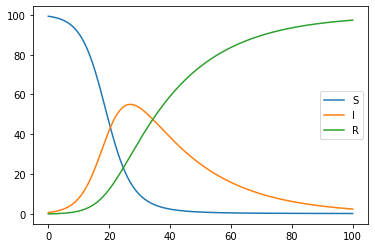

In [2]:
## SIR MODEL

def SIR(y,t,beta,gamma,N):
    S = y[0]
    I = y[1]
    R = y[2]
    dS_dt = -beta(t) * I * S/N 
    dI_dt = beta(t) * I * S/N - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def beta(t):
    beta=0.3
#    if t>18: beta=0.8 
#    if t>22: beta=0.3  
    return beta

gamma=1/21;   # recovery rate: time  it takes to recover from the disease and stop being contagious
N=1e2;       # total population

T=100;
dt=0.01;
N_times=np.int(T/dt)

N_infected=0.007*N;


y0 = [N-N_infected,N_infected,0]
t = np.linspace(0,T,N_times) 
args = (beta,gamma,N)
res = odeint(SIR,y0,t,args)


plt.plot(t,res[:,0],label="S")
plt.plot(t,res[:,1],label="I")
plt.plot(t,res[:,2],label="R")
plt.legend()
plt.show()

Utilities

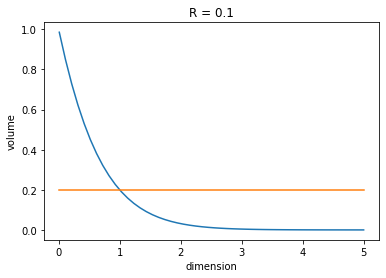

In [4]:

#volume of a ball of radius R in d dimensions
def V_ball(R,d):
    return np.pi**(d/2.0)* R**d / math.gamma(d/2.0+1)
#radius of a ball of volume V in d dimensions
def R_ball(V,d):
    return (math.gamma(d/2.0+1) / np.pi**(d/2.0) * V)**(1.0/d)

R = 0.1
d = np.linspace(0.01,5,50)
plt.plot(d,V_ball(R,d))
plt.plot(d,V_ball(R_ball(0.2,d),d))
plt.xlabel("dimension")
plt.ylabel("volume")
plt.title(f"R = {R}")
plt.show()


In [5]:
# drift that I renamed d_torus bc I use it in the kernel as well
L=1
def d_torus(y,y0):
    
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    
    return ydrift

y0,y = np.array([0,0,0,0]), np.array([.1,-.1,.1,-.1])
x0,x = np.array([0,0,0,0]), np.array([.1,.1,-.1,-.1])

z0 = np.array([y0,x0])
z = np.array([y,x])

d_torus(z[:,:],z0[:,:])

array([[-0.1,  0.1, -0.1,  0.1],
       [-0.1, -0.1,  0.1,  0.1]])


# SDE

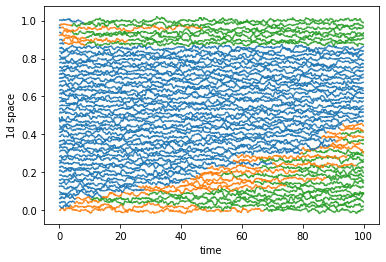

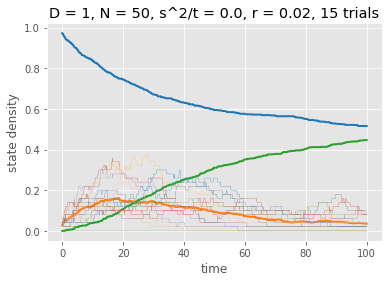

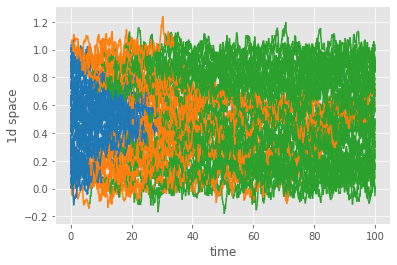

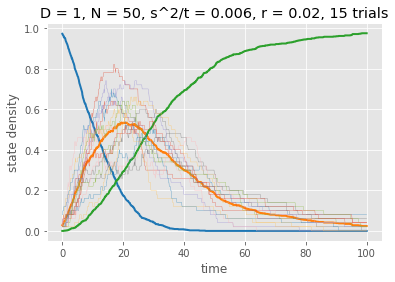

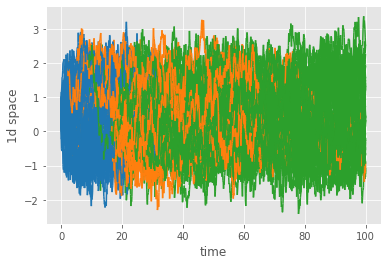

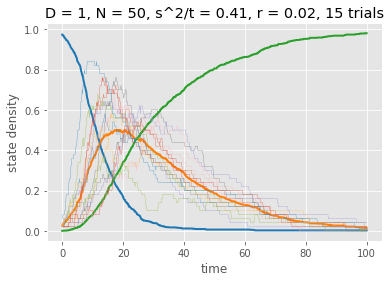

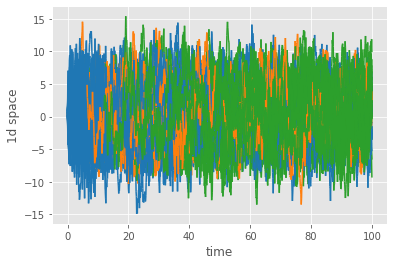

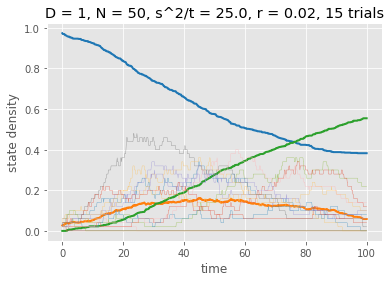

In [6]:
# SDE IN 1D (VECTORIALIZED BUT DOESN'T WORK ;P -- problem with the poisson probably)
D = 1
t_end=100;
length = 1000
L = 1
N = 40 * L

def d_torus(y,y0):
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    return ydrift

def w(y,s,r):
    ret = np.exp(-(d_torus(y,np.transpose(y)))**2/(2*r**2))
    ret[:,(s != 1)] = 0
    np.fill_diagonal(ret,0)
    return np.sum(ret,1)
#    return np.exp(-np.mod(y-np.transpose(y),L)**2/(2*sig**2))# * 1/np.sqrt(2*np.pi * sig**2)
#    return (1-np.tanh(100*abs(y_i-y_j)-sig))/2
                  

def plot_trajectories(y,s,t):
    plt.figure()
    ax = plt.axes()
    for n in range(N):
        yp = y[0,n,:]
        sp = s[n,:]
        segments_t = np.r_[t[0], t[1:-1].repeat(2), t[-1]].reshape(-1, 2)
        segments_y = np.r_[yp[0], yp[1:-1].repeat(2), yp[-1]].reshape(-1, 2)
        segments_s = np.r_[sp[0], sp[1:-1].repeat(2), sp[-1]].reshape(-1, 2)
        linecolors = [co[int(s[n,i])] for i in range(length)] #[co[0] if s_[0] == 0 and s_[1] == 0 else co[1] for s_ in segments_s]
        segments = [np.column_stack([t_, y_]) for t_, y_ in zip(segments_t, segments_y)]
        ax.add_collection(LineCollection(segments, colors=linecolors))
    ax.autoscale_view()
    #plt.ylim((y[0,0]+(2*L/N),y[0,0]-2*L/N))
    #plt.xlim((0,t_end))
    plt.xlabel("time")
    plt.ylabel("1d space")
    plt.show()
    
def plot_densities(s_stat,N,sigma,theta,r,IT,D):
    im = plt.figure()
    plt.style.use('ggplot')
    for state in range(3):
        plt.plot(t,np.mean(np.mean(s_stat[:,:,:]==state,1),0),linewidth=2,color=co[state])
    for it in range(IT):
        plt.plot(t,np.mean(s_stat[it,:,:]==1,0),linewidth=.3)
    plt.xlabel("time")
    plt.ylabel("state density")
    plt.title(f"D = {D}, N = {N}, s^2/t = {round(sigma**2/theta,3)}, r = {r}, {IT} trials")
    plt.show()

c = mcolors.TABLEAU_COLORS
co = [c['tab:blue'],c['tab:orange'],c['tab:green'],c['tab:orange']]

t = np.linspace(0,t_end,length) 
dt = np.mean(np.diff(t)) 

gamma = 1/21 *dt
prop_infected = .007


def d_torus(y,y0):
    ydrift = y0-y
    ydrift2 = np.sign(-ydrift) * (L-abs(ydrift))
    c = (abs(ydrift) > L/2.0)
    ydrift[c] = ydrift2[c]
    return ydrift
def poisson_R(s, gamma): 
    p = np.random.poisson(lam=gamma,size=len(s))
    p[(s != 1)] = 0
    return p
def poisson_I(s, y, beta, r):
    p = np.random.poisson(lam=beta*w(y,s,r),size=len(s))
    p[(s != 0)] = 0
    return p


drift_y = lambda y, y0: d_torus(y,y0)
drift_s = lambda s, s0: s0-s 
diffusion = lambda y, sigma: sigma 

    
S, I, R = 0, 1, 2

for sigma in [.01,.08,.64,5]:
    N=50
    theta  = 1
#    sigma = 5
    r = R_ball(.04,1)
    beta = 12 *dt / N
    
    multi_mean = np.zeros(N)
    multi_cov = np.diag(np.ones(N))
    noise = np.zeros((1,length,N))
    
    y = np.zeros((1,N,length))
    y0 = np.zeros((1,N))
    s = np.zeros((N,length))
    
    IT = 15
    s_stat = np.zeros((IT,N,length))
    for it in range(IT):            #run several (IT) iterations 
        
        noise[0,:,:] = np.random.multivariate_normal(mean=multi_mean,cov=multi_cov,size=length)*np.sqrt(dt) #define noise process
        
        y0[:,:] = np.linspace(0,1,N) #np.random.uniform(low=0,high=L,size=N)
        y[:,:,0] = y0
        
        s_p = np.random.rand(N)
        s[:,0] = [np.int(s_p[i]<prop_infected) for i in range(N)]
        s[0,0] = 1
        
        for i in range(1,length):
            y[:,:,i] = y[:,:,i-1] + theta * drift_y(y[:,:,i-1],y[:,:,0])*dt + diffusion(y[:,:,i-1], sigma)*noise[:,i,:]
            s[:,i] = s[:,i-1] + drift_s(s[:,i-1],I)*poisson_I(s[:,i-1],y[:,:,i-1],beta,r) + drift_s(s[:,i-1],R)*poisson_R(s[:,i-1],gamma)
        s_stat[it,:,:]=s[:,:]


     #plot trajectories for one instance
    plot_trajectories(y,s,t)
    plot_densities(s_stat,N,sigma,theta,r,IT,D)

    

In [353]:
np.mean(np.random.poisson(lam=[1,2,3],size=(20,3)),0)

array([0.95, 2.15, 3.45])

In [69]:
## 2D SDE (HAVEN'T ADDED THE DRIFT OR VECTORIALED DISTANCE YET)
D = 2
t_end=100;
length = 1000
L = 1

def d(y_i,y_j,sig):  #infection kernel
#    return np.exp(-np.mod(y_i-y_j,2)**2/(2*sig**2))# * 1/np.sqrt(2*np.pi * sig**2)
    return np.exp(-(sum(np.mod(y_i[l]-y_j[l],L)**2 for l in range(len(y_i))))/(2*sig**2)) # * 1/np.sqrt(2*np.pi * sig**2)
#    return (1-np.tanh(100*abs(y_i-y_j)-sig))/2
                  
def R_ball(V,d):    #radius of a d-dim ball of constant volume V
    return (math.gamma(d/2.0 + 1) / np.pi**(d/2.0) * V)**(1.0/d)


r = 0.2
gamma = 1/21 *dt
prop_infected = .007

t = np.linspace(0,t_end,length) 
dt = np.mean(np.diff(t))

def drift(y,y0):
    y0,y = y0[0],y[0]
    x0,x = y0[1],y[1]
    
    ydrift = np.array(y0-y)
    ydrift[(abs(ydrift) > L/2.0)] = np.sign(y-y0)* (L-abs(y0-y))
    
    xdrift = np.array(x0-x)
    xdrift[(abs(xdrift) > L/2.0)] = np.sign(x-x0)* (L-abs(x0-x))
    
    return [ydrift xdrift]
a = np.array([1,2,3,4,5])


diffusion = lambda y, sigma: sigma    

poisson_R = lambda n, s, gamma: np.random.poisson(lam=gamma) if s[n]==1 else 0
poisson_I = lambda n, s, y, beta, r: np.random.poisson(lam=beta*sum([d(y[:,n],y[:,m],r) for m in range(len(y)) if s[m]==1 and n!=m])) if s[n]==0 else 0 
I, R = 1, 2


for b in [300,75,12,3]:
    N=70
    theta  = .5  
    sigma = 2 
    r = R_ball(0.01,D)
    beta = b *dt / N**(1.0/D**2)
    
    multi_mean = np.zeros(N)
    multi_cov = np.diag(np.ones(N))
    noise = np.zeros((D,length,N))
    
    y = np.zeros((D,N,length))
    y0 = np.zeros((D,N))
    s = np.zeros((N,length))
    
    IT = 15
    s_stat = np.zeros((IT,N,length))
    for it in range(IT):            #run several (IT) iterations 
        
        for a in range(D):          #initialise noise and y0 in D dimensions
            noise[a,:,:] = np.random.multivariate_normal(mean=multi_mean,cov=multi_cov,size=length)*np.sqrt(dt) #define noise process
            y0[a,:] = np.random.uniform(low=0,high=L,size=N)
        
        y[:,:,0] = y0
        
        s_p = np.random.rand(N)
        s[:,0] = [np.int(s_p[i]<prop_infected) for i in range(N)]
        s[0,0] = 1                  #Make sure at least one person is infected

        for i in range(1,length):
            y[:,:,i] = y[:,:,i-1] + theta * drift(y[:,:,i-1],y[:,:,0])*dt + diffusion(y[:,:,i-1], sigma)*noise[:,i,:]
            for n in range(N):
                s[n,i] = s[n,i-1] + drift(s[n,i-1],I)*poisson_I(n,s[:,i-1],y[:,:,i-1],beta,r) + drift(s[n,i-1],R)*poisson_R(n,s[:,i-1],gamma)
        s_stat[it,:,:]=s[:,:]


    im = plt.figure()
    plt.style.use('ggplot')
    for state in range(3):
        plt.plot(t,np.mean(np.mean(s_stat[:,:,:]==state,1),0),linewidth=2,color=co[state])
    for it in range(IT):
        plt.plot(t,np.mean(s_stat[it,:,:]==1,0),linewidth=.3)
    plt.xlabel("time")
    plt.ylabel("state density")
    plt.title(f"D = {D}, N = {N}, s^2/t = {round(sigma**2/theta,4)}, r = {round(r,3)}, {IT} trials")
    plt.show()


array([[ 0.        , -0.04098452, -0.06346667, ...,  0.91793831,
         0.89258237,  0.94437352],
       [ 0.04098452,  0.        , -0.02248215, ...,  0.95892283,
         0.93356689,  0.98535804],
       [ 0.06346667,  0.02248215,  0.        , ...,  0.98140498,
         0.95604904,  1.00784019],
       ...,
       [-0.91793831, -0.95892283, -0.98140498, ...,  0.        ,
        -0.02535594,  0.02643522],
       [-0.89258237, -0.93356689, -0.95604904, ...,  0.02535594,
         0.        ,  0.05179115],
       [-0.94437352, -0.98535804, -1.00784019, ..., -0.02643522,
        -0.05179115,  0.        ]])

In [273]:
np.exp(-(drift(y,np.Inf)**2/(2*sigma**2))

0.0